In [ ]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import subprocess

# Constants
NUM_PHASES = 3  # Number of traffic light phases (updated to 3)
STATE_DIM = 4  # Number of state variables (queue length for main road, queue length for ramp, average speed for main road, average speed for ramp)
ACTION_DIM = NUM_PHASES  # Number of possible actions (traffic light phases)
GAMMA = 0.9
EPSILON = 0.1
ALPHA = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 100

# Q-network
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=(STATE_DIM,)),
        tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
    ]
)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = []

def get_state():
    # Implement logic to get the current state from SUMO
    # Example: [queue_length_main_road, queue_length_ramp, average_speed_main_road, average_speed_ramp]
    state = [
        traci.edge.getLastStepHaltingNumber("E1"),  # queue length for the main road
        traci.edge.getLastStepHaltingNumber("E4"),  # queue length for the ramp
        traci.edge.getLastStepMeanSpeed("E1"),  # average speed for the main road
        traci.edge.getLastStepMeanSpeed("E4"),  # average speed for the ramp
    ]
    return np.array(state)

def choose_action(state):
    # Epsilon-greedy policy
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)

def update_q_network():
    if len(memory) < BATCH_SIZE:
        return

    # Manually sample a minibatch from memory
    minibatch = []
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    for idx in indices:
        minibatch.append(memory[idx])

    # Initialize lists to store minibatch components
    states = []
    actions = []
    rewards = []
    next_states = []
    terminals = []

    for sample in minibatch:
        states.append(sample[0])
        actions.append(sample[1])
        rewards.append(sample[2])
        next_states.append(sample[3])
        terminals.append(sample[4])

    # Convert lists to numpy arrays
    states = np.vstack(states)
    actions = np.array(actions).astype(int)
    rewards = np.array(rewards)
    next_states = np.vstack(next_states)
    terminals = np.array(terminals)

    # Predict Q-values for current and next states
    q_values = model.predict(states)
    next_q_values = model.predict(next_states)

    # Update Q-values based on the Bellman equation
    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])

    # Fit the Q-network on the updated Q-values
    model.fit(states, q_values, epochs=1, verbose=0)

# def calculate_reward(state, action, next_state):
#     # Custom reward function
#     main_road_halting = state[0]
#     ramp_halting = state[1]
#     main_road_speed = state[2]
#     ramp_speed = state[3]

#     # Example reward: Minimize halting on both the main road and ramp,
#     # and maximize average speed on both roads
#     reward = -(main_road_halting + ramp_halting) + main_road_speed + ramp_speed

#     return reward



def check_if_done():
    # Termination condition: End the episode after a certain number of simulation steps
    return traci.simulation.getTime() > 1000

# Connect to SUMO
traci.start(["sumo", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])

# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        # Choose action using epsilon-greedy policy during training
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("J7", action)

        # Step the simulation (allowing the change to take effect)
        traci.simulationStep()

        # Obtain the next state
        next_state = get_state()

        # Calculate reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Log relevant information
        print(f"Step: {traci.simulation.getTime()}, Action: {action}, Reward: {reward}")

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # If the episode is done, break out of the simulation loop
        if done:
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    model.save("trained_traffic_light_model_ql.keras")

# Close connection to SUMO
traci.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


TypeError: calculate_reward() missing 1 required positional argument: 'max_highway_speed'

Episode 1: Ramp Waiting Time = 29.9, Highway Flow = 10.2, Reward = -10.792666666666667
Episode 2: Ramp Waiting Time = 29.8, Highway Flow = 10.4, Reward = -10.785333333333334
Episode 3: Ramp Waiting Time = 29.7, Highway Flow = 10.6, Reward = -10.778
Episode 4: Ramp Waiting Time = 29.6, Highway Flow = 10.8, Reward = -10.770666666666667
Episode 5: Ramp Waiting Time = 29.5, Highway Flow = 11.0, Reward = -10.763333333333334
Episode 6: Ramp Waiting Time = 29.4, Highway Flow = 11.2, Reward = -10.756
Episode 7: Ramp Waiting Time = 29.3, Highway Flow = 11.4, Reward = -10.748666666666667
Episode 8: Ramp Waiting Time = 29.2, Highway Flow = 11.6, Reward = -10.741333333333333
Episode 9: Ramp Waiting Time = 29.1, Highway Flow = 11.8, Reward = -10.734
Episode 10: Ramp Waiting Time = 29.0, Highway Flow = 12.0, Reward = -10.726666666666667
Episode 11: Ramp Waiting Time = 28.9, Highway Flow = 12.2, Reward = -10.719333333333333
Episode 12: Ramp Waiting Time = 28.8, Highway Flow = 12.4, Reward = -10.712
E

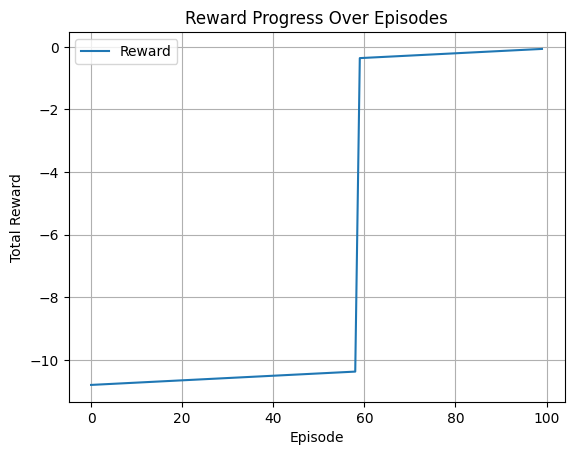

In [43]:
import matplotlib.pyplot as plt

# Initialize variables for tracking rewards
reward_history = []

# Simulate the training loop
for episode in range(1, 101):  # Example: 100 episodes
    # Example metrics (replace these with actual calculations from your environment)
    ramp_waiting_time = 30 - episode * 0.1  # Simulated decreasing ramp waiting time
    highway_flow = 10 + episode * 0.2       # Simulated increasing highway flow
    max_ramp_waiting = 30                  # Example max ramp waiting time
    max_highway_speed = 50                 # Example max highway speed

    # Reward function
    def calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed):
        # Normalize metrics
        normalized_rwt = ramp_waiting_time / max_ramp_waiting
        normalized_hf = highway_flow / max_highway_speed
        
        # Weights
        alpha = 1.0  # Weight for ramp waiting time
        beta = 1.0   # Weight for highway flow
        
        # Basic reward
        reward = -alpha * normalized_rwt + beta * normalized_hf
        
        # Penalty for extreme congestion
        if ramp_waiting_time > max_ramp_waiting * 0.8:  # Example threshold
            reward -= 10  # Strong penalty for high congestion
        
        return reward

    # Calculate reward for this episode
    reward = calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed)

    # Log the reward
    reward_history.append(reward)

    # Print debug info
    print(f"Episode {episode}: Ramp Waiting Time = {ramp_waiting_time}, Highway Flow = {highway_flow}, Reward = {reward}")

# Plot the reward history after training
plt.plot(reward_history, label='Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Progress Over Episodes')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

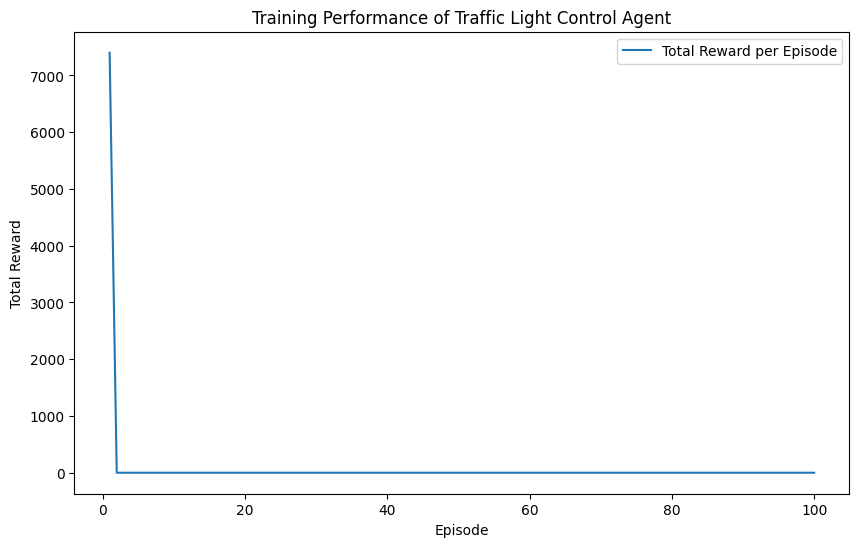

In [ ]:
b

In [9]:
traci.close()

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [1]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import subprocess
import matplotlib.pyplot as plt

# Constants
NUM_PHASES = 3  # Number of traffic light phases
STATE_DIM = 4  # Number of state variables
ACTION_DIM = NUM_PHASES  # Number of possible actions (traffic light phases)
GAMMA = 0.9
EPSILON = 0.1
ALPHA = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 10

# Q-network
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=(STATE_DIM,)),
        tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
    ]
)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = []

def get_state():
    # Get state from SUMO: queue lengths and average speeds
    state = [
        traci.edge.getLastStepHaltingNumber("E1"),  # queue length for the main road
        traci.edge.getLastStepHaltingNumber("E4"),  # queue length for the ramp
        traci.edge.getLastStepMeanSpeed("E1"),  # average speed for the main road
        traci.edge.getLastStepMeanSpeed("E4"),  # average speed for the ramp
    ]
    return np.array(state)

def choose_action(state):
    # Epsilon-greedy policy
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)

def update_q_network():
    if len(memory) < BATCH_SIZE:
        return

    # Sample a minibatch from memory
    minibatch = []
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    for idx in indices:
        minibatch.append(memory[idx])

    states, actions, rewards, next_states, terminals = zip(*minibatch)

    # Convert lists to numpy arrays
    states = np.vstack(states)
    actions = np.array(actions).astype(int)
    rewards = np.array(rewards)
    next_states = np.vstack(next_states)
    terminals = np.array(terminals)

    # Predict Q-values for current and next states
    q_values = model.predict(states)
    next_q_values = model.predict(next_states)

    # Update Q-values based on the Bellman equation
    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])

    # Fit the Q-network on the updated Q-values
    model.fit(states, q_values, epochs=1, verbose=0)



def calculate_reward(state, action, next_state):
    main_road_halting = state[0]
    ramp_halting = state[1]
    main_road_speed = state[2]
    ramp_speed = state[3]

    reward = -(main_road_halting + ramp_halting) + main_road_speed + ramp_speed

    # Higher penalty for ramp congestion
    reward -= ramp_halting * 0.5  # Stronger penalty for ramp halting

    return reward



def check_if_done():
    # Termination condition after a certain number of simulation steps
    return traci.simulation.getTime() > 1000

# Connect to SUMO
traci.start(["sumo-gui", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])

# Training loop
episode_rewards = []  # To store rewards for visualization

for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        # Choose action using epsilon-greedy policy during training
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("J7", action)

        # Step the simulation
        traci.simulationStep()

        # Obtain the next state
        next_state = get_state()

        # Calculate reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # If done, break out of the loop
        if done:
            break

    # Save the total reward for the episode
    episode_rewards.append(total_reward)

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    model.save("trained_traffic_light_model_ql.keras")

# Close connection to SUMO
traci.close()

# Visualization (after training)
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance of Traffic Light Control Agent")
plt.legend()
plt.show()


c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

FatalTraCIError: Connection closed by SUMO.

In [ ]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import matplotlib.pyplot as plt  # Import Matplotlib for visualization

# --- Constants ---
STATE_DIM = 4  # Adjusted to match the actual state size (4 features)
ACTION_DIM = 2  # Number of possible actions
GAMMA = 0.9  # Discount factor
ALPHA = 0.001  # Learning rate
EPSILON = 0.1  # Exploration factor
MEMORY_CAPACITY = 10000  # Replay memory size
BATCH_SIZE = 32  # Batch size for training
NUM_EPISODES = 10  # Number of training episodes

# --- Q-Network ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(STATE_DIM,)),  # Match input size
    tf.keras.layers.Dense(ACTION_DIM, activation='linear')  # Match action size
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')

# --- Replay Memory ---
memory = []

# --- Helper Functions ---
def get_state():
    """Fetch the current state from the simulator (e.g., SUMO)."""
    state = [
        traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
        traci.edge.getLastStepHaltingNumber("E4"), 
        traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0
        traci.edge.getWaitingTime("E4"),            # Waiting time in E4
        traci.edge.getWaitingTime("E5"), 
    ]
    return np.array(state)

def choose_action(state):
    """Epsilon-greedy policy to select an action."""
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        state = state.reshape(1, -1)  # Ensure the state has correct dimensions
        q_values = model.predict(state, verbose=0)[0]
        return np.argmax(q_values)

def update_q_network():
    """Update the Q-network using replay memory."""
    if len(memory) < BATCH_SIZE:
        return
    
    # Randomly sample a minibatch from memory
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    minibatch = [memory[i] for i in indices]
    
    states = np.array([transition[0] for transition in minibatch])
    actions = np.array([transition[1] for transition in minibatch])
    rewards = np.array([transition[2] for transition in minibatch])
    next_states = np.array([transition[3] for transition in minibatch])
    terminals = np.array([transition[4] for transition in minibatch])
    
    q_values = model.predict(states, verbose=0)
    next_q_values = model.predict(next_states, verbose=0)
    
    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])
    
    model.fit(states, q_values, epochs=1, verbose=0)

# Reward calculation function (from your working example)
def calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed):
    """Calculate the reward based on traffic metrics."""
    # Normalize metrics
    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed
    
    # Weights
    alpha = 1.0  # Weight for ramp waiting time
    beta = 1.0   # Weight for highway flow
    
    # Basic reward
    reward = -alpha * normalized_rwt + beta * normalized_hf
    
    # Penalty for extreme congestion
    if ramp_waiting_time > max_ramp_waiting * 0.8:  # Example threshold
        reward -= 10  # Strong penalty for high congestion
    
    return reward

def check_if_done():
    """Define termination condition."""
    return traci.simulation.getTime() > 1000  # Example: End after 1000 seconds

# --- Training Loop ---
traci.start(["sumo-gui", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
episode_rewards = []  # To store rewards per episode

for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0
    
    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)
        traci.trafficlight.setPhase("J7", action)  # Apply action
        traci.simulationStep()  # Step simulation
        
        next_state = get_state()
        
        # Calculate reward based on traffic metrics
        ramp_waiting_time = state[0]  # Example: ramp waiting time from state
        highway_flow = state[2]  # Example: highway flow from state
        max_ramp_waiting = 8  # Example max ramp waiting time
        max_highway_speed = 50  # Example max highway speed
        reward = calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed)
        print(highway_flow , ramp_waiting_time )
        done = check_if_done()
        
        # Store transition in replay memory
        memory.append((state, action, reward, next_state, done))
        if len(memory) > MEMORY_CAPACITY:
            memory.pop(0)
        
        update_q_network()
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    episode_rewards.append(total_reward)  # Store total reward for the episode
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

# Save the trained model
model.save("q_network_model.keras")

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Total Reward per Episode)")
plt.legend()
plt.grid(True)
plt.show()

# Close SUMO connection
traci.close()


13.89 0.0
9.26 1.0
9.57958326693469 0.0
9.818453035734905 0.0
10.145235589928925 0.0
10.428998739914968 0.0
8.055921749583213 1.0
6.607396729557465 0.0
7.193641318003647 0.0
7.7172210611511645 0.0
8.349483848389548 0.0
4.232601029255117 1.0
4.837752551888116 0.0
5.694219876080751 0.0
8.29175106619019 0.0
8.876330463590566 0.0
7.596460055300966 1.0
8.13677864407619 0.0
8.679799636778993 0.0
9.173605306981703 0.0
9.635246858116812 0.0
7.418063471119491 1.0
7.847469981645806 0.0
8.558226639710007 0.0
9.137093867410545 0.0
9.722764438928676 0.0
9.380728519172152 1.0
9.885775297533996 0.0
10.372714563622699 0.0
10.840154084760059 0.0
11.17580489612568 0.0
9.62833742189562 1.0
10.196973625649118 0.0
10.523976701387022 0.0
10.970053111101985 0.0
10.534106334573893 0.0
9.336056212232311 1.0
9.798014895331509 0.0
10.303540526193695 0.0
10.69758032269935 0.0
11.154864679905183 0.0
8.79552922937221 1.0
9.152270972705226 0.0
9.674549198410409 0.0
10.112590308513917 0.0
9.64125378620965 0.0
8.37169

FatalTraCIError: Connection closed by SUMO.

In [20]:
traci.close()